<a href="https://colab.research.google.com/github/ziatdinovmax/GPim/blob/master/examples/notebooks/GP_EELS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Parallel" Gaussian process for Electron Energy Loss Spectroscopy (EELS) data



---


Application of "parallel GP" method for analysis of electron energy loss spectroscopy (EELS) data. The method operates on the full spatial domain and reduced representations in the energy
domain.


---





Notebook prepared by Sergei V. Kalinin and Maxim Ziatdinov (April 2020)

Install GPim:

In [ ]:
!python3 -m pip install gpim > /dev/null

Import needed modules:

In [2]:
import gpim
import numpy as np
from sklearn import decomposition
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

(Down)load data:

In [3]:
!wget -qq -O eels.npy "https://github.com/ziatdinovmax/GPim/blob/master/expdata/eels.npy?raw=true"
hdata = np.load("eels.npy")

The dataset is EELS data from LAO-STO obtained by Andrew Lupini (ORNL). 

Let's "flatten" the spatial dimensions of this dataset and normalize it for the decomposition analysis:

In [4]:
X_vec = hdata.copy()
d1, d2, d3 = X_vec.shape
X_vec = X_vec.reshape(d1*d2, d3)
X_vec = (X_vec - np.min(X_vec)) / np.ptp(X_vec)

We are now going to reduce the dataset in the energy dimension using the standard decomposition techniques such as principal component analysis (PCA) and non-negative matrix factorization (NMF). We can get an idea about how many PCA/NMF components are needed to describe the dataset using PCA scree plot:

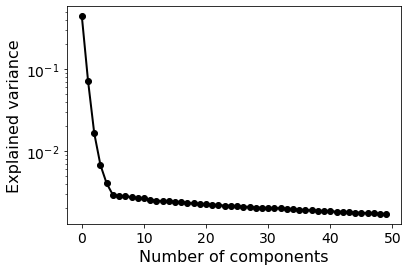

In [5]:
pca = decomposition.PCA()
pca.fit(X_vec)
plt.plot(pca.explained_variance_ratio_[0:50], '-o', linewidth=2, c='black')
plt.xlabel('Number of components', fontsize = 16)
plt.ylabel('Explained variance', fontsize = 16)
plt.tick_params(labelsize = 14)
plt.yscale("log")

Let's do decomposition for 12 components:

In [6]:
# Select number of components
nc = 12 
# Select decomposition type ('PCA' or 'NMF')
decomposition_type = 'NMF'

# Run decomposition
if decomposition_type == 'NMF':
    clf = decomposition.NMF(n_components=nc, random_state=42)
elif decomposition_type == 'PCA':
    clf = decomposition.PCA(n_components=nc, random_state=42)
else:
    raise NotImplementedError('Available methods: "PCA", "NMF"')
X_vec_t = clf.fit_transform(X_vec)
components = clf.components_
components = components.reshape(nc, d3)
print(components.shape, X_vec_t.shape)

(12, 1340) (2304, 12)


Plot the decomposition results:

NUMBER OF COMPONENTS: 12
Components...


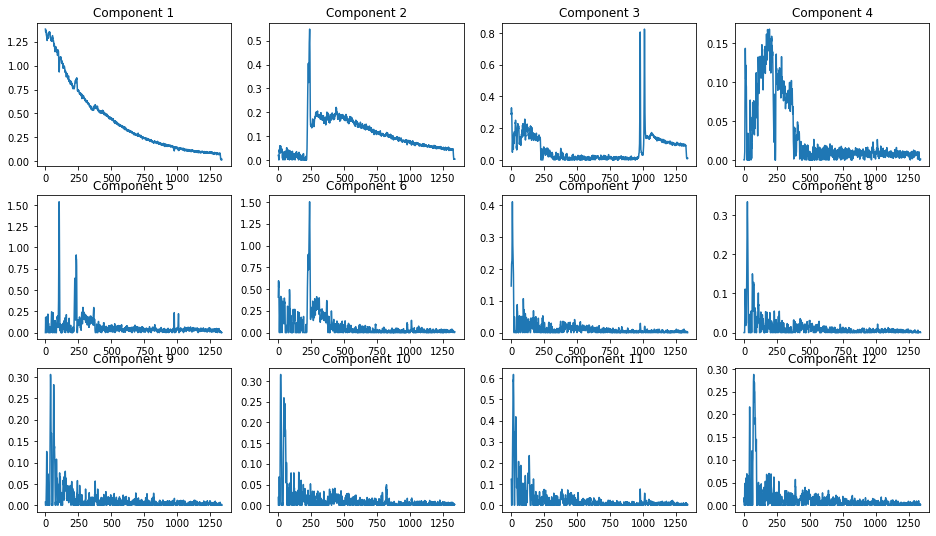

Abundance maps...


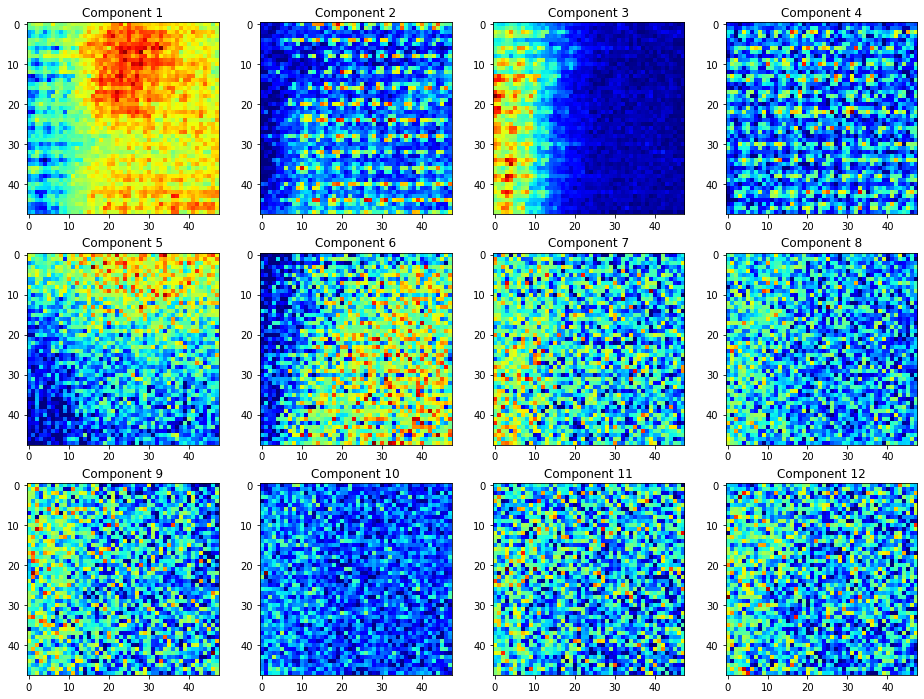

In [7]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))

print('NUMBER OF COMPONENTS: ' + str(nc))
print('Components...')
gs1 = gridspec.GridSpec(rows, cols)
fig1 = plt.figure(figsize = (4*cols, 3.5*(1+rows)//1.5))   
for i in range(nc):
    ax1 = fig1.add_subplot(gs1[i])
    j = 0
    ax1.plot(components[i])
    ax1.set_title('Component {}'.format(i + 1))
plt.show()

print('Abundance maps...')
gs2 = gridspec.GridSpec(rows, cols)
fig2 = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))   
for i in range(nc):
    ax2 = fig2.add_subplot(gs2[i])
    ax2.imshow(X_vec_t[:, i].reshape(d1, d2), cmap = 'jet')
    ax2.set_title('Component {}'.format(i + 1))
plt.show()

Based on the decompostions results we are going to perform "parallel" GP on the first 6 components. Here, the information between the components is shared via a common
spatial kernel structure while allowing for variability in the relative noise magnitude or image
morphology. For this, we are going to use model that learns a shared covariance function on
input-dependent features as first demonstrated [in this paper](https://papers.nips.cc/paper/3189-multi-task-gaussian-process-prediction.pdf).

In [8]:
Z = X_vec_t[:, :6].reshape(d1, d2, 6) # form an image stack with 6 components

grid_density = 2 # density of grid for prediction with a trained model 

X = gpim.utils.get_full_grid(Z[...,0], dense_x= 1) # training grid
Xtest = gpim.utils.get_full_grid(Z[...,0], dense_x=(1/grid_density)) # grid for prediction

# Train "parallel" GP:
vrec = gpim.vreconstructor(X, Z, Xtest, kernel='Matern52', 
                           lengthscale=[0.5, 2.5], isotropic=False,
                           learning_rate=0.05, use_gpu=True,
                           iterations=200, verbose=2)

vrec.train()

Model training...
iter: 0 ... loss: 3021.7781 ... length: [1.525 1.525] ...
iter: 10 ... loss: 2517.3352 ... length: [1.7652 1.7652] ...
average time per iteration: 3.2159999999999997 s
iter: 20 ... loss: 1986.1338 ... length: [1.9642 1.9642] ...
iter: 30 ... loss: 1410.5245 ... length: [2.1076 2.1076] ...
iter: 40 ... loss: 789.2827 ... length: [2.2021 2.2022] ...
iter: 50 ... loss: 186.5469 ... length: [2.263  2.2631] ...
iter: 60 ... loss: -439.387 ... length: [2.3052 2.3053] ...
iter: 70 ... loss: -1059.8519 ... length: [2.3357 2.3359] ...
iter: 80 ... loss: -1675.9897 ... length: [2.3588 2.359 ] ...
iter: 90 ... loss: -2276.103 ... length: [2.3767 2.377 ] ...
iter: 100 ... loss: -2850.7288 ... length: [2.3908 2.3912] ...
iter: 110 ... loss: -3388.1156 ... length: [2.402  2.4027] ...
iter: 120 ... loss: -3871.1357 ... length: [2.4111 2.412 ] ...
iter: 130 ... loss: -4285.4984 ... length: [2.4182 2.4196] ...
iter: 140 ... loss: -4623.178 ... length: [2.4238 2.4257] ...
iter: 150 ...

Make predcition with a trained model:

In [9]:
mean, sd = vrec.predict(Xtest)

Calculating predictive mean and uncertainty...
Batch 1/1
Done


Plot the results:

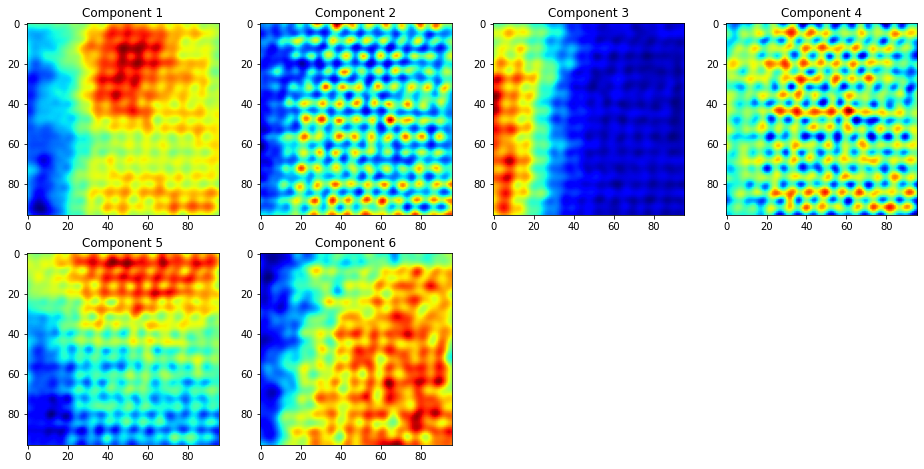

In [10]:
rows = int(np.ceil(float(nc)/5))
cols = int(np.ceil(float(nc)/rows))


gs2 = gridspec.GridSpec(rows, cols)
fig = plt.figure(figsize = (4*cols, 4*(1+rows//1.5)))  

for i in range(6):
    ax = fig.add_subplot(gs2[i])
    ax.imshow(mean[..., i].reshape(96, 96), cmap = 'jet')
    ax.set_title('Component ' + str(i + 1))
plt.show()

The "parallel" GP clearly allows us to reconstruct the atomic-scale features in these
components. However, analysis of a larger number of components does not lead to further
improvement. Using 7 components leads to partial degradation of contrast and then a full loss of
atomic periodicities for 8 components. This reveals that the model is effectively using
knowledge from the lower noise components in the reconstruction of the weaker signals. 